In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 70 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':70}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('../RiverRoad_Quan_RF.csv')

In [9]:
def SVSM(X, y, gridid):
    fig, ax = plt.subplots()

    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]
        
        tuned_parameters = [{'C': [-10000, -1000, -100, -10, 0, 10, 100, 1000, 1000],
                     'gamma': [0.01,0.001]}]
        model = SVC(kernel='rbf')

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for SVC")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt

5it [00:26,  5.38s/it]

26.89415550000001 seconds
[0.8299477655252466, 0.8176538908246226, 0.8217189314750291, 0.832171893147503, 0.8176538908246226]
0.8238292743594048 accuracy
[[1874 1270]
 [ 247 5220]]
              precision    recall  f1-score   support

           0     0.8835    0.5961    0.7119      3144
           1     0.8043    0.9548    0.8731      5467

    accuracy                         0.8238      8611
   macro avg     0.8439    0.7754    0.7925      8611
weighted avg     0.8332    0.8238    0.8143      8611



NameError: name 'roc' is not defined

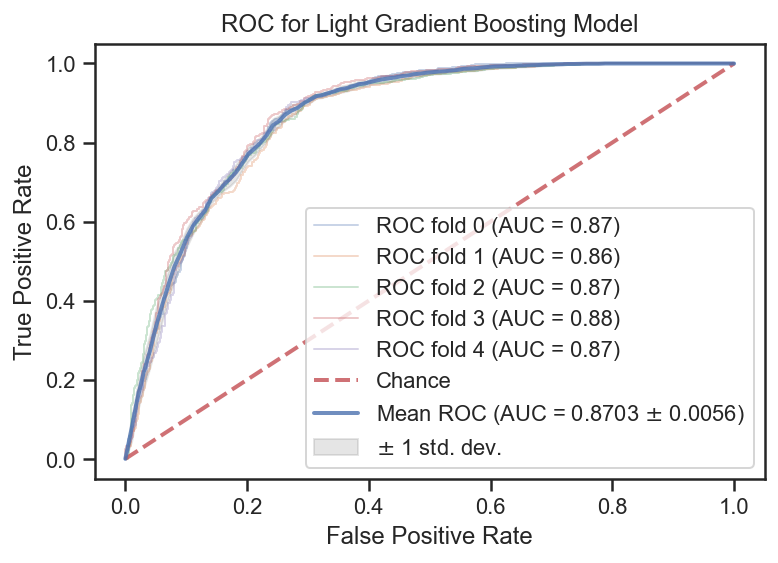

In [10]:
X = df.drop(['GRID_ID', 'wetland_type', 'wetland', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_60, time_60, cm_60, cr_60, acc_60, roc_60 = SVSM(X, y, gridid)
print(f"{time_60} seconds")
print(f"{acc_60}")
print(f"{np.mean(acc_60)} accuracy")
print(cm_60)
print(cr_60)
print(roc_60)

In [ ]:
tuned_parameters = [{'C': [-10000, -1000, -100, -10, 0, 10, 100, 1000, 1000],
                     'gamma': [0.01,0.001]}]
model = GridSearchCV(SVC(kernel="rbf"), tuned_parameters, cv=5, scoring='accuracy')
model.fit(X, y)